In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./Desktop/machine-learning-master/data/csv/basketball_stat.csv')

In [3]:
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True)

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import numpy as pd

In [6]:
def svc_param_selection(X, y, nfolds):
    svm_parameters = [
        {
            'kernel': ['rbf'],
            'gamma': [0.00001, 0.0001, 0.001, 0.01, .1, 1],
            'C': [.01, .1, 1, 10, 100, 1000]
        }
    ]
    # 사이킷런에서 제공하는 GridSearchCV를 사용해 최적의 파라미터를 구함
    clf = GridSearchCV(SVC(), svm_parameters, cv = 10)
    clf.fit(X_train, y_train.values.ravel())
    print(clf.best_params_)
    
    return clf

In [8]:
# 3점슛과 블로킹 횟수를 학습 데이터로 사용
X_train = train[['3P', 'BLK']]

# 농구선수 포지션을 예측값으로 선정
y_train = train[['Pos']]

,3P,BLK
48,0.5,1.0
80,1.2,0.4
42,1.6,0.2
71,0.0,0.6
97,1.8,0.4
...,...,...
14,2.0,0.2
52,0.6,0.8
83,0.5,0.7
95,0.3,1.0


In [12]:
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [13]:
# 시각화할 비용 후보들을 저장
C_candidates = []
C_candidates.append(clf.best_params_['C'] * 0.01)
C_candidates.append(clf.best_params_['C'])
C_candidates.append(clf.best_params_['C'] * 100)

# 시각화할 감마 후보들을 저장
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)

In [15]:
X = train[['3P', 'BLK']]

Y = train['Pos'].tolist()

In [21]:
# 시각화를 위해 센터(C)와 슈팅가드(SG)를 숫자로 표현
position = []
for gt in Y:
    if gt == 'C':
        position.append(0)
    else:
        position.append(1)

In [22]:
# 파라미터 후보들을 조합해서 학습된 모델들을 저장
classifiers = []

for C in C_candidates:
    for gamma in gamma_candidates:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))

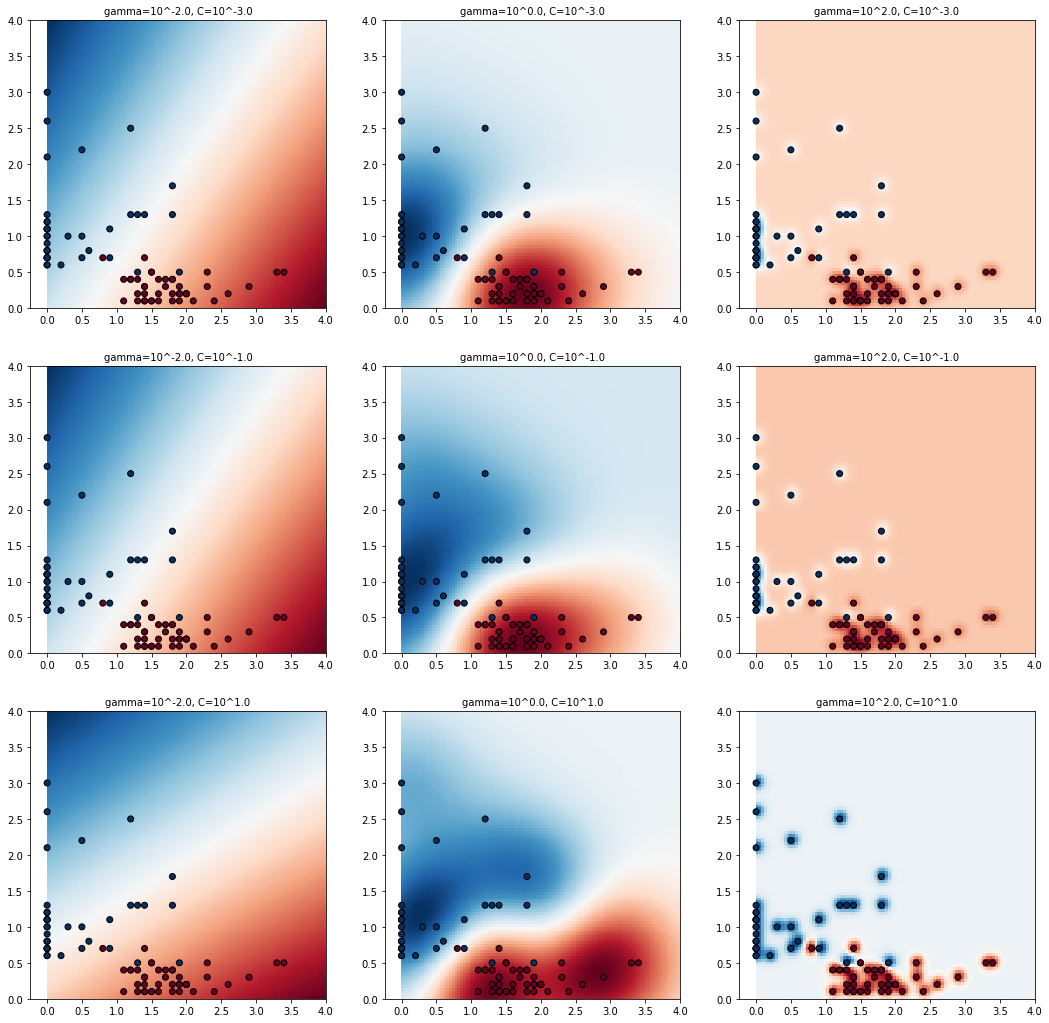

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 각 모델을 시각화
# 가운데가 best_param
plt.figure(figsize=(18,18))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))

for k, (C, gamma, clf) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.subplot(len(C_candidates), len(gamma_candidates), k+1)
    plt.title(f"gamma=10^{np.log10(gamma)}, C=10^{np.log10(C)}", size='medium')
    
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r, edgecolors='k')

In [28]:
X_test = test[['3P', 'BLK']]
y_test = test[['Pos']]

# 최적의 파라미터로 학습된 모델로 테스트를 진행
y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred), '\n')
print(f"accuracy: {accuracy_score(y_true, y_pred)}")

              precision    recall  f1-score   support

           C       0.92      1.00      0.96        11
          SG       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20
 

accuracy: 0.95


In [29]:
# 눈으로 비교
comparison = pd.DataFrame({'prediction': y_pred,
                          'ground_truth': y_true.values.ravel()})
comparison

,prediction,ground_truth
0,SG,SG
1,C,C
2,C,C
3,C,C
4,SG,SG
5,C,C
6,SG,SG
7,C,C
8,C,C
9,SG,SG
